In [0]:
  

%pip install -qU langchain langchain-community langchain-core sqlalchemy langchain_experimental matplotlib mlflow langgraph fsspec huggingface_hub youtube-search openai langchain-databricks langchain_openai

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:

dbutils.library.restartPython()

In [0]:
%run ./sql_tool

/home/spark-e520fb41-a888-4fea-8ced-7f/.ipykernel/37720/command-1271219866574295-3532097706:3: LangChainDeprecationWarning: The class `ChatDatabricks` was deprecated in LangChain 0.3.3 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-databricks package and should be used instead. To use it run `pip install -U :class:`~langchain-databricks` and import as `from :class:`~langchain_databricks import ChatDatabricks``.
  chat_model = ChatDatabricks(endpoint="databricks-meta-llama-3-1-405b-instruct", max_tokens=4000)


In [0]:
%run ./python_tool

In [0]:
%run ./youtube_tool

In [0]:
%run ./feedback_tool

In [0]:
import mlflow 
mlflow.langchain.autolog()

In [0]:

import os
import getpass
from langchain_databricks import ChatDatabricks
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_core.tools import Tool, BaseTool
from langchain.agents import AgentType, initialize_agent,create_structured_chat_agent
from langchain_openai import ChatOpenAI
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage, FunctionMessage, HumanMessage, ToolMessage, SystemMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages, AnyMessage
from langgraph.graph import StateGraph, END
from IPython.display import Image, display

/home/spark-e520fb41-a888-4fea-8ced-7f/.ipykernel/37720/command-1074436159912867-893220778:15: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  llm_chain = LLMChain(llm=llm, prompt=feedback_prompt, verbose=False)


In [0]:


os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI Token: ")
main_llm =  ChatOpenAI(model="gpt-4o")

OpenAI Token:  [REDACTED]

In [0]:
# Alternative main llm
# main_llm = ChatDatabricks(endpoint="databricks-meta-llama-3-1-70b-instruct", max_tokens=4000)

In [0]:

tools = [sql_tool, python_tool, feedback_tool, youtube_tool, ]
llm_with_tools = main_llm.bind_tools(tools)

In [0]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

def call_model(state:AgentState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state:AgentState):
    messages = state["messages"]
    last_message = messages[-1]

    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"
    
tool_node = ToolNode(tools)
    

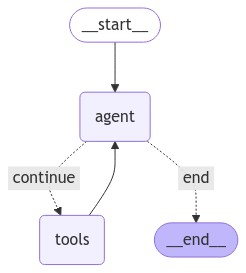

In [0]:
workflow = StateGraph(AgentState)

workflow.add_node("agent",call_model)
workflow.add_node("tools", tool_node)

workflow.set_entry_point("agent")

workflow.add_conditional_edges("agent", 
                                should_continue,
                                {
                                    "continue": "tools",
                                    "end": END
                                }
                                )
workflow.add_edge("tools", "agent")
new_app = workflow.compile()

display(Image(new_app.get_graph(xray=True).draw_mermaid_png()))

In [0]:
inputs = {"messages": [HumanMessage(content="show me Sophia's total score for each month, and give training feedback based on the performance")]}

output = new_app.invoke(inputs)

for m in output["messages"]:
    m.pretty_print()

2024/10/26 08:04:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/local_disk0/.ephemeral_nfs/envs/pythonEnv-e520fb41-a888-4fea-8ced-7fbd101b82cb/lib/python3.10/site-packages/mlflow/utils/autologging_utils/safety.py:460: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead."


================================ Human Message =================================

show me Sophia's total score for each month, and give training feedback based on the performance
================================== Ai Message ==================================
Tool Calls:
  sql_agent (call_d3855169-4051-488b-aa09-50c241f1d4e5)
 Call ID: call_d3855169-4051-488b-aa09-50c241f1d4e5
  Args:
    __arg1: SELECT date_trunc(
================================= Tool Message =================================
Name: sql_agent

SELECT date_trunc('month', month) FROM qa_table LIMIT 10
================================== Ai Message ==================================
Tool Calls:
  feedback_agent (call_d15db271-c56a-44b4-8fce-22010088b7aa)
 Call ID: call_d15db271-c56a-44b4-8fce-22010088b7aa
  Args:
    __arg1: SELECT date_trunc(
================================= Tool Message =================================
Name: feedback_agent

To provide training feedback for the customer support agent based on the `qa_f

Trace(request_id=tr-d6b30197282243489160f82815bd09f9)

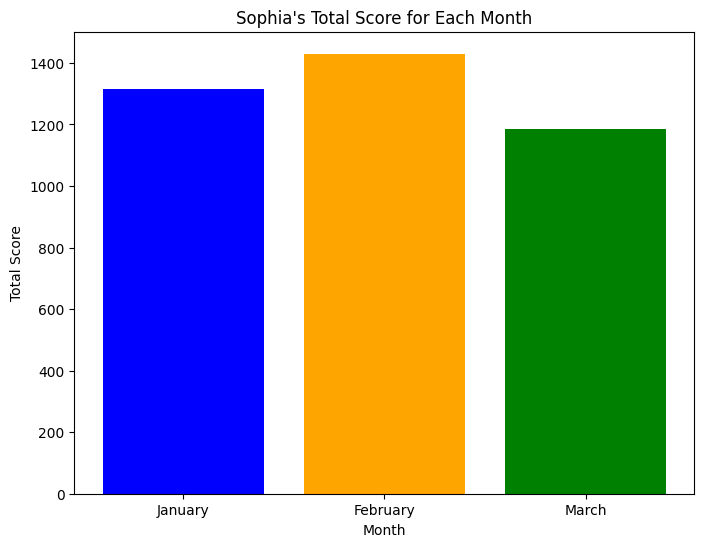

================================ Human Message =================================

generate a bar chart to show Sophia's total score for each month
================================== Ai Message ==================================
Tool Calls:
  sql_agent (call_Xj1IIgdToq6P8F0P1jbYRkuP)
 Call ID: call_Xj1IIgdToq6P8F0P1jbYRkuP
  Args:
    __arg1: SELECT MONTH, SUM(SCORE) AS TOTAL_SCORE FROM SOPHIA_SCORES GROUP BY MONTH
================================= Tool Message =================================
Name: sql_agent

The total score for each month is: February - 1430, January - 1315, March - 1186.
================================== Ai Message ==================================
Tool Calls:
  python_repl (call_m1WaYjiCYK68DtG7oF7JsSvW)
 Call ID: call_m1WaYjiCYK68DtG7oF7JsSvW
  Args:
    __arg1: import matplotlib.pyplot as plt

# Data for Sophia's total score for each month
months = ['January', 'February', 'March']
total_scores = [1315, 1430, 1186]

# Create a bar chart
plt.figure(figsize=(8, 6)

Trace(request_id=tr-9daf8f1e71404972b19be880430dbcda)

In [0]:
inputs = {"messages": [HumanMessage(content="generate a bar chart to show Sophia's total score for each month")]}

output = new_app.invoke(inputs)

for m in output["messages"]:
    m.pretty_print()

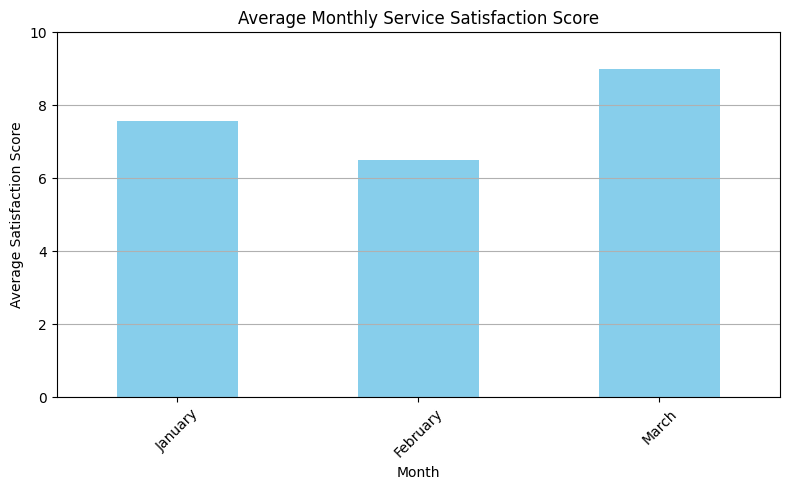

================================ Human Message =================================

analyse monthly service satisfaction score, generate the plot
================================== Ai Message ==================================
Tool Calls:
  sql_agent (call_tIFozuU5sqv2w0JQWX6QL5VM)
 Call ID: call_tIFozuU5sqv2w0JQWX6QL5VM
  Args:
    __arg1: SELECT month, satisfaction_score FROM service_satisfaction
================================= Tool Message =================================
Name: sql_agent

[('February', 8), ('January', 6), ('January', 7), ('January', 7), ('February', 7), ('January', 8), ('January', 9), ('January', 8), ('March', 9), ('February', 6)]
================================== Ai Message ==================================
Tool Calls:
  python_repl (call_wRVPJdmNv272tmC4BH02IqgK)
 Call ID: call_wRVPJdmNv272tmC4BH02IqgK
  Args:
    __arg1: import matplotlib.pyplot as plt
import pandas as pd

# Data
data = {
    'Month': ['January', 'January', 'January', 'January', 'February', 'J

Trace(request_id=tr-9592aaaa250c458a8f195ff4e482741e)

In [0]:
inputs = {"messages": [HumanMessage(content="analyse monthly service satisfaction score, generate the plot")]}

output = new_app.invoke(inputs)

for m in output["messages"]:
    m.pretty_print()

In [0]:
inputs = {"messages": [HumanMessage(content="provide a youtube video suggestion for Sophia to improve her greeting and closing skills when talking to a customer")]}

output = new_app.invoke(inputs)

for m in output["messages"]:
    m.pretty_print()

================================ Human Message =================================

provide a youtube video suggestion for Sophia to improve her greeting and closing skills when talking to a customer
================================== Ai Message ==================================
Tool Calls:
  youtube_search (call_u37AhGSdaUelV4F3hI0FLnRP)
 Call ID: call_u37AhGSdaUelV4F3hI0FLnRP
  Args:
    query: improve greeting and closing skills in customer service
================================= Tool Message =================================
Name: youtube_search

['https://www.youtube.com/watch?v=oe6OXbzPj-I&pp=ygU3aW1wcm92ZSBncmVldGluZyBhbmQgY2xvc2luZyBza2lsbHMgaW4gY3VzdG9tZXIgc2VydmljZQ%3D%3D', 'https://www.youtube.com/watch?v=LRJXMKZ4wOw&pp=ygU3aW1wcm92ZSBncmVldGluZyBhbmQgY2xvc2luZyBza2lsbHMgaW4gY3VzdG9tZXIgc2VydmljZQ%3D%3D']
================================== Ai Message ==================================

Here are some YouTube videos that can help Sophia improve her greeting and closing skills

Trace(request_id=tr-07871183c4444c1e9102b8e8310cc649)